Loaded signal 'EEG Fp1-REF' with 3603000 samples at 500.0 Hz.
Total data points per channel: 3603000.0
Start: 0, Stop: 3603000, Sample Amount: 20000
180


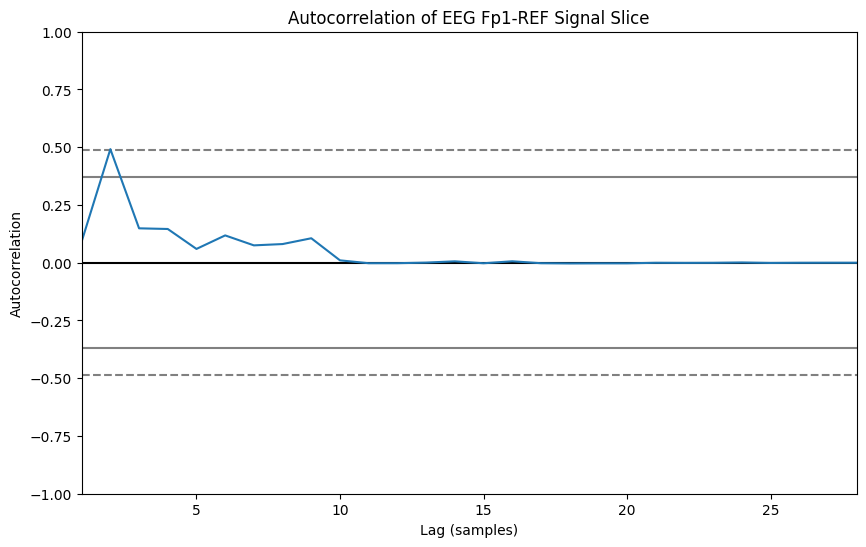

ValueError: x is required to have ndim 1 but has ndim 2

In [ ]:
import pyedflib
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
# Set plotting style
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

def read_eeg_data(file_path):
    """Reads an EDF file and returns signal data and metadata."""
    with pyedflib.EdfReader(file_path) as f:
        # Get all signals and metadata
        signal_labels = f.getSignalLabels()
        sample_rate = f.getSampleFrequency(0)
        signals = [f.readSignal(i) for i in range(len(signal_labels))]
        duration = f.getFileDuration()

    return signals, signal_labels, sample_rate, duration

path = "seizure_eeg_data/01.edf"
all_signals, signal_labels, sample_rate, duration = read_eeg_data(path)
# 20k samples
sample_amount = 20000

signal_one = all_signals[0]
print(f"Loaded signal '{signal_labels[0]}' with {len(signal_one)} samples at {sample_rate} Hz.")
data_points_per_channel = duration * sample_rate
print(f"Total data points per channel: {data_points_per_channel}")
start = 0
stop = int(data_points_per_channel / sample_rate) * 500 # 500 seconds
print(f"Start: {start}, Stop: {stop}, Sample Amount: {sample_amount}")
step = int(stop / sample_amount)
print(step)
signal_slice = signal_one[start:stop:step]

axes = pd.plotting.autocorrelation_plot(signal_one)
axes.set_title(f"Autocorrelation of {signal_labels[0]} Signal Slice")
plt.xlabel("Lag (samples)")
plt.ylabel("Autocorrelation")
plt.grid()
plt.show()

adf_result = adfuller(signal_one)
print(adf_result)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
if adf_result[1] < 0.05:
    print("The time series is stationary (reject null hypothesis).")
else:
    print("The time series is non-stationary (fail to reject null hypothesis).")


# Downsampled signal
plt.figure(figsize=(15, 4))
plt.plot(signal_slice[:1000]) 
plt.title("Downsampled Signal (First 1000 points)")
plt.show()

